Reference: https://github.com/joosthub/PyTorchNLPBook/blob/master/chapters/chapter_7/7_3_surname_generation/7_3_Model2_Conditioned_Surname_Generation.ipynb

Generate surnames with the help of nationality.

# Imports

In [1]:
from argparse import Namespace 
from collections import Counter 
import json 
import os 
import string
import numpy as np 
import pandas as pd
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Vocabulary

In [2]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):
        """ token_to_idx (dict): a pre-existing map of tokens to indices """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ contents is a dict with keys token_to_idx, add_unk, and unk_token """
        return cls(**contents)

    def add_token(self, token):
        """ token: str """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def lookup_token(self, token):
        return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)
    
    
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>", 
                 mask_token="<MASK>", begin_seq_token="<BEGIN>", end_seq_token="<END>"):
        
        super(SequenceVocabulary, self).__init__(token_to_idx)
        
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token
        self._unk_token = unk_token
        self._mask_token = mask_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token) 
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)
        
    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """ token: str """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

# Vectorizer

In [3]:
class SurnameVectorizer(object):
    def __init__(self, char_vocab, nationality_vocab):
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    # surname = "word1 word2 word3"
    # from_vector = [begin_index, idx1, idx2, idx3, mask_idx, ..., mask_idx]
    # to_vector = [idx1, idx2, idx3, end_index, mask_idx, ..., mask_idx]
    def vectorize(self, surname, vector_length=-1):
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token) for token in surname)
        indices.append(self.char_vocab.end_seq_index)
            
        if vector_length < 0:
            vector_length = len(indices)

        from_vector = np.empty(vector_length, dtype=np.int64)
        from_indices = indices[:-1]
        from_vector[:len(from_indices)] = from_indices
        from_vector[len(from_indices):] = self.char_vocab.mask_index
            
        to_vector = np.empty(vector_length, dtype=np.int64)
        to_indices = indices[1:]
        to_vector[:len(to_indices)] = to_indices
        to_vector[len(to_indices):] = self.char_vocab.mask_index
        
        return from_vector, to_vector
    
    @classmethod
    def from_dataframe(cls, surname_df):
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()
        
        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)
        
        return cls(char_vocab, nationality_vocab)
    
    @classmethod
    def from_serializable(cls, contents):
        char_vocab = SequenceVocabulary.from_serializable(contents['char_vocab'])
        nationality_vocab = Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(char_vocab=char_vocab, nationality_vocab=nationality_vocab)

    def to_serializable(self):
        return {'char_vocab': self.char_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}

# Dataset

In [4]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2
        
        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        surname_df = pd.read_csv(surname_csv)
        return cls(surname_df, SurnameVectorizer.from_dataframe(surname_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)
    
    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer
    
    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    # used in generate_batches()
    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        from_vector, to_vector = self._vectorizer.vectorize(row.surname, self._max_seq_length)
        nationality_index = self._vectorizer.nationality_vocab.lookup_token(row.nationality)
        
        return {'x_data': from_vector, 'y_target': to_vector, 'class_index': nationality_index}
        # 'class_index' is not used in this unconditioned surname generation

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

In [5]:
def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}      
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

# Model

* nationality_index.shape: (batch_size,)

* nationality_embedded = nn.Embedding(num_nationalities, rnn_hidden_size)(nationality_index)

    * nationality_embedded.shape: (batch_size, rnn_hidden_size) 

* nationality_embedded.unsqueeze_(dim=0)
 
    * nationality_embedded.shape: (1, batch_size, rnn_hidden_size)
    * nationality_embedded is used as the initial hidden state of the RNN
    
* y_out, _ = GRU_model(x_embedded, nationality_embedded)  

In [7]:
class SurnameGenerationModel(nn.Module):
    def __init__(self, char_embedding_size, char_vocab_size, num_nationalities, rnn_hidden_size,
                 batch_first=True, padding_idx=0, dropout_p=0.5):
        
        super(SurnameGenerationModel, self).__init__()
        
        self.char_emb = nn.Embedding(num_embeddings=char_vocab_size, embedding_dim=char_embedding_size, padding_idx=padding_idx)
        
        self.nation_emb = nn.Embedding(num_embeddings=num_nationalities, embedding_dim=rnn_hidden_size)

        self.rnn = nn.GRU(input_size=char_embedding_size, hidden_size=rnn_hidden_size, batch_first=batch_first)
        
        self.fc = nn.Linear(rnn_hidden_size, char_vocab_size)
        
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x_in, nationality_index, apply_softmax=False):
        # x_in.shape: (batch_size, seq_size)
        # nationality_index is used to initialize the hidden state of the RNN
        
        x_embedded = self.char_emb(x_in)   
            # x_embedded.shape: (batch_size, seq_size, embedding_size)
        nationality_embedded = self.nation_emb(nationality_index).unsqueeze(0) 
            # nationality_embedded.shape: (1, batch_size, rnn_hidden_size)
            # nationality_embedded is used as the initial hidden state in rnn() below.
        y_out, _ = self.rnn(x_embedded, nationality_embedded)    
            # y_out.shape: (batch_size, seq_size, rnn_hidden_size)
            # nationality_embedded is the initial hidden state of shape (1, batch_size, rnn_hidden_size)
            # _ is the last hidden state of the same shape as nationality_embedded

        batch_size, seq_size, feat_size = y_out.shape
        y_out = y_out.contiguous().view(-1, feat_size)    # y_out.shape: (batch_size*seq_size, rnn_hidden_size)
        y_out = self.fc(self.dropout(y_out))              # y_out.shape: (batch_size*seq_size, char_vocab_size)

        if apply_softmax:
            y_out = torch.softmax(y_out, dim=1)

        y_out = y_out.view(batch_size, seq_size, y_out.shape[-1])
        return y_out   # (batch_size, seq_size, char_vocab_size)

# Helper functions

In [9]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


# update_train_state() is called at the end of each epoch of the validation process.

def update_train_state(args, model, train_state):
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False
    else:
        loss_t = train_state['val_loss'][-1]

        if loss_t >= train_state['early_stopping_best_val']:
            train_state['early_stopping_step'] += 1
        else:
            torch.save(model.state_dict(), train_state['model_filename'])
            train_state['early_stopping_step'] = 0

        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def normalize_sizes(y_pred, y_true):
    if len(y_pred.size()) == 3:                               # If y_pred.shape is (batch_size, seq_size, vocab_size),
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2)) # change it to (batch_size*seq_size, vocab_size)
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)                   # If y_true.shape is (batch_size, seq_size),
    return y_pred, y_true                                     # change it to (batch_size*seq_size)
    
def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    _, y_pred_indices = y_pred.max(dim=1)

    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()

    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()
    return n_correct / n_valid * 100


def sequence_loss(y_pred, y_true, mask_index):
    # y_pred.shape: (batch_size*seq_size, char_vocab_size)
    # y_true.shape: (batch_size, seq_size)
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    # y_pred.shape: (batch_size*seq_size, char_vocab_size)
    # y_true.shape: (batch_size*seq_size,)
    return nn.functional.cross_entropy(y_pred, y_true, ignore_index=mask_index)


def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
        
def sample_from_model(model, vectorizer, nationalities, sample_size=20, temperature=1.0):
    # nationalities (list): a list of integers representing nationalities
    num_samples = len(nationalities)
    begin_seq_index = [vectorizer.char_vocab.begin_seq_index for _ in range(num_samples)]
    begin_seq_index = torch.tensor(begin_seq_index, dtype=torch.int64).unsqueeze(dim=1)
        # begin_seq_index.shape: (num_samples, 1)
    
    indices = [begin_seq_index]
    nationality_indices = torch.tensor(nationalities, dtype=torch.int64).unsqueeze(dim=0)
        # nationality_indices.shape: (1, num_samples)
    h_t = model.nation_emb(nationality_indices)
        # h_t.shape: (1, num_samples, rnn_hidden_size)
    
    for time_step in range(sample_size):
        x_t = indices[time_step]
        x_emb_t = model.char_emb(x_t)
        rnn_out_t, h_t = model.rnn(x_emb_t, h_t)
        prediction_vector = model.fc(rnn_out_t.squeeze(dim=1))
        probability_vector = torch.softmax(prediction_vector / temperature, dim=1)
        indices.append(torch.multinomial(probability_vector, num_samples=1))
    indices = torch.stack(indices).squeeze().permute(1, 0)
    return indices  # shape: (num_samples, sample_size)

def decode_samples(sampled_indices, vectorizer):
    decoded_surnames = []
    vocab = vectorizer.char_vocab
    
    for sample_index in range(sampled_indices.shape[0]):
        surname = ""
        for time_step in range(sampled_indices.shape[1]):
            sample_item = sampled_indices[sample_index, time_step].item()
            if sample_item == vocab.begin_seq_index:
                continue
            elif sample_item == vocab.end_seq_index:
                break
            else:
                surname += vocab.lookup_index(sample_item)
        decoded_surnames.append(surname)
        
    return decoded_surnames

# Settings

In [10]:
args = Namespace(
    # Data and Path information
    model_state_file='model.pth',
    surname_csv='../data/surnames_with_splits.csv',
    save_dir='model_storage/',
    vectorizer_file='vectorizer.json',
    # Model hyper parameters
    char_embedding_size=32,
    rnn_hidden_size=32,
    # Training hyper parameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=50,
    seed=1337,
    # Runtime options
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/vectorizer.json
	model_storage/model.pth
Using CUDA: False


# Initialization

In [11]:
if args.reload_from_files:
    print("Loading dataset and vectorizer")
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv, args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)    

vectorizer = dataset.get_vectorizer()
model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               num_nationalities=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index,
                               dropout_p=0.5)

Loading dataset and creating vectorizer


# Training loop

In [13]:
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)
# scheduler.step(train_state['val_loss'][-1]) is called at the end of each epoch of the validation process. 
# Then the scheduler adjusts the learning rate based on the latest validation loss.

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        dataset.set_split('train')
        
        batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
        running_loss = 0.0
        running_acc = 0.0

        model.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            optimizer.zero_grad()                       # batch_dict['x_data'].shape: (batch_size, seq_size)
            y_pred = model(x_in=batch_dict['x_data'], nationality_index=batch_dict['class_index'])
            
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)   # batch_dict['y_target'].shape:
            loss.backward()                                                    # (batch_size, seq_size)
            optimizer.step()
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        dataset.set_split('val')
        
        batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
        running_loss = 0.
        running_acc = 0.

        model.eval()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            y_pred = model(x_in=batch_dict['x_data'], nationality_index=batch_dict['class_index'])
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, train_state=train_state)

        if train_state['stop_early']:
            break
 
        nationalities = np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)
        model = model.cpu()
        sampled_surnames = decode_samples(sample_from_model(model, vectorizer, nationalities=nationalities), vectorizer)
        sample1 = "{}->{}".format(vectorizer.nationality_vocab.lookup_index(nationalities[0]), sampled_surnames[0])
        sample2 = "{}->{}".format(vectorizer.nationality_vocab.lookup_index(nationalities[1]), sampled_surnames[1])
        epoch_bar.set_postfix(sample1=sample1, sample2=sample2)
        model = model.to(args.device)
        
        scheduler.step(train_state['val_loss'][-1])
        train_bar.n = 0
        val_bar.n = 0
        
        epoch_bar.update()

except KeyboardInterrupt:
    print("Exiting loop")

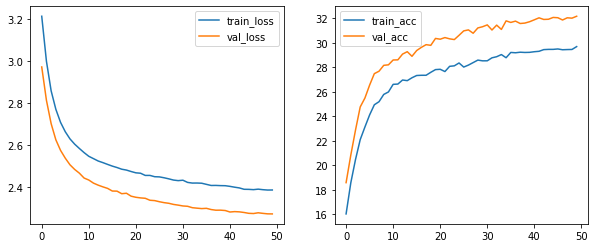

In [14]:
epochs = range(0, epoch_index+1)
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
ax.plot(epochs, train_state['train_loss'], label="train_loss")
ax.plot(epochs, train_state['val_loss'], label="val_loss")
ax.legend();

ax = fig.add_subplot(122)
ax.plot(epochs, train_state['train_acc'], label="train_acc")
ax.plot(epochs, train_state['val_acc'], label="val_acc")
ax.legend();

# Performance

In [15]:
model.load_state_dict(torch.load(train_state['model_filename']))
model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)

running_acc = 0.

model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    y_pred = model(x_in=batch_dict['x_data'], nationality_index=batch_dict['class_index'])
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
    running_loss += (loss.item() - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 2.277
Test Accuracy: 31.93


# Inference

In [16]:
model = model.cpu()
for index in range(len(vectorizer.nationality_vocab)):
    nationality = vectorizer.nationality_vocab.lookup_index(index)
    print("Sampled for {}: ".format(nationality))
    sampled_indices = sample_from_model(model, vectorizer,  
                                        nationalities=[index] * 3, 
                                        temperature=0.7)
    for sampled_surname in decode_samples(sampled_indices, vectorizer):
        print("-  " + sampled_surname)

Sampled for Arabic: 
-  Temy
-  Bakhoh
-  Nuitrit
Sampled for Chinese: 
-  Figa
-  Zom
-  Chiu
Sampled for Czech: 
-  Pachis
-  Honitin
-  Usoma
Sampled for Dutch: 
-  Chart
-  Reudofon
-  Myedein
Sampled for English: 
-  Donlidn
-  Taghas
-  Gerer
Sampled for French: 
-  Ate
-  Lagor
-  Gums
Sampled for German: 
-  Sheunon
-  Kend
-  Shannor
Sampled for Greek: 
-  Cuoroeri
-  Perudae
-  Kunosen
Sampled for Irish: 
-  Panjin
-  Talri
-  O'Sertel
Sampled for Italian: 
-  Tinara
-  Arrali
-  Sirlson
Sampled for Japanese: 
-  Tiita
-  Rakisi
-  Mamarosome
Sampled for Korean: 
-  Peus
-  Jaoe
-  Sun
Sampled for Polish: 
-  Ruiwekon
-  Mockan
-  Cerbab
Sampled for Portuguese: 
-  Isoas
-  Mobowi
-  Bonsan
Sampled for Russian: 
-  Phazaschev
-  Lanekin
-  Vovemev
Sampled for Scottish: 
-  Kerin
-  Ablal
-  Weovin
Sampled for Spanish: 
-  Ararai
-  Allarei
-  Silan
Sampled for Vietnamese: 
-  Al
-  Sa
-  Vow
